In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess


def get_git_root():
    """Get the root directory of the git repository"""
    try:
        git_root = (
            subprocess.check_output(
                ["git", "rev-parse", "--show-toplevel"], stderr=subprocess.DEVNULL
            )
            .strip()
            .decode("utf-8")
        )
        return git_root
    except (subprocess.CalledProcessError, FileNotFoundError):
        return None


# Change to git root
git_root = get_git_root()
if git_root:
    os.chdir(git_root)
    print(f"Changed to git root: {os.getcwd()}")
else:
    print("Not in a git repository or git not found")

Changed to git root: /Users/sherman/GitHub/CSE-6748


In [3]:
import pickle

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [4]:
X_index = pd.read_parquet("data/cleaned/X_index.parquet")
X = pd.read_parquet("data/cleaned/X.parquet")
Y = pd.read_parquet("data/cleaned/Y.parquet")

In [5]:
# Train/test split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=69,
)

In [ ]:
# Define the parameter grid to search
param_dist = {
    "iterations": randint(1000, 5000),  # Number of trees
    "learning_rate": uniform(0.01, 0.2),  # Learning rate
    "depth": randint(4, 10),  # Depth of trees
    "l2_leaf_reg": uniform(1, 10),  # L2 regularization
    "random_strength": uniform(0.1, 1.0),  # Random strength for split
    "bagging_temperature": uniform(0, 1),  # Bagging temperature for features
    "border_count": randint(32, 255),  # Border count for splits
}

# Set up the CatBoost model for cross-validation
cv_model = CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    random_seed=42,
    verbose=0,
    task_type="CPU",
)

# Create the RandomizedSearchCV object
search = RandomizedSearchCV(
    estimator=cv_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to try
    cv=5,  # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,  # Use all available processors
    verbose=2,
)

print("Starting hyperparameter search with cross-validation. This may take a while...")


# Fit the RandomizedSearchCV
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
search.fit(X_train, Y_train, cat_features=categorical_features)

# Print the best parameters
print("\nBest parameters found:")
print(search.best_params_)
print(f"\nBest cross-validation RMSE: {-search.best_score_:.4f}")

Starting hyperparameter search with cross-validation. This may take a while...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bagging_temperature=0.3745401188473625, border_count=124, depth=6, iterations=2095, l2_leaf_reg=6.986584841970366, learning_rate=0.0412037280884873, random_strength=0.2559945203362026; total time=13.9min
[CV] END bagging_temperature=0.3745401188473625, border_count=124, depth=6, iterations=2095, l2_leaf_reg=6.986584841970366, learning_rate=0.0412037280884873, random_strength=0.2559945203362026; total time=13.9min
[CV] END bagging_temperature=0.3745401188473625, border_count=124, depth=6, iterations=2095, l2_leaf_reg=6.986584841970366, learning_rate=0.0412037280884873, random_strength=0.2559945203362026; total time=13.9min
[CV] END bagging_temperature=0.3745401188473625, border_count=124, depth=6, iterations=2095, l2_leaf_reg=6.986584841970366, learning_rate=0.0412037280884873, random_strength=0.2559945203362026; total time=13.9min
[CV] E

/Users/sherman/GitHub/CSE-6748/ai-coach/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bagging_temperature=0.5247564316322378, border_count=120, depth=4, iterations=1474, l2_leaf_reg=7.118528947223795, learning_rate=0.03789877213040837, random_strength=0.39214464853521813; total time= 1.9min
[CV] END bagging_temperature=0.5247564316322378, border_count=120, depth=4, iterations=1474, l2_leaf_reg=7.118528947223795, learning_rate=0.03789877213040837, random_strength=0.39214464853521813; total time= 1.9min
[CV] END bagging_temperature=0.5247564316322378, border_count=120, depth=4, iterations=1474, l2_leaf_reg=7.118528947223795, learning_rate=0.03789877213040837, random_strength=0.39214464853521813; total time= 1.9min
[CV] END bagging_temperature=0.7219987722668247, border_count=189, depth=9, iterations=3433, l2_leaf_reg=2.818249672071006, learning_rate=0.046680901970686764, random_strength=0.4042422429595377; total time=17.8min
[CV] END bagging_temperature=0.7219987722668247, border_count=189, depth=9, iterations=3433, l2_leaf_reg=2.818249672071006, learning_rate=0.

In [ ]:
# Train a new model with the best parameters
best_model = CatBoostRegressor(
    **search.best_params_,
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    random_seed=42,
    verbose=500,
)

# Fit the model with best parameters
best_model.fit(
    X_train,
    Y_train,
    cat_features=categorical_features,
)

0:	learn: 168.4670801	total: 19.5ms	remaining: 1m 9s
500:	learn: 86.5932461	total: 10.6s	remaining: 1m 5s
1000:	learn: 81.9372673	total: 20.3s	remaining: 52s
1500:	learn: 78.6437123	total: 30.5s	remaining: 41.9s
2000:	learn: 75.8681296	total: 41.3s	remaining: 32.3s
2500:	learn: 73.5061812	total: 51.5s	remaining: 21.9s
3000:	learn: 71.2827295	total: 1m 1s	remaining: 11.6s
3500:	learn: 69.2600379	total: 1m 11s	remaining: 1.31s
3564:	learn: 69.0276672	total: 1m 13s	remaining: 0us


In [ ]:
# Save the CatBoost model to a pickle file
with open("models/catboost_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("CatBoost model saved as pickle to models/catboost_model.pkl")

CatBoost model saved as pickle to models/catboost_model.pkl


In [9]:
# Load the model from pickle
with open("models/catboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [10]:
# Predict & evaluate
y_pred_best = best_model.predict(X_valid)
rmse_best = np.sqrt(mean_squared_error(Y_valid, y_pred_best))

print(f"Tuned CatBoost RMSE: {rmse_best:.4f}")

Tuned CatBoost RMSE: 63.3794


In [11]:
y_pred_int = np.round(y_pred_best, 0).astype(int)

# Create comparison DataFrame
comparison_df = pd.merge(
    X_index,
    pd.DataFrame(
        {
            "sat_math_score": Y_valid["sat_math_score"],
            "sat_verbal_score": Y_valid["sat_verbal_score"],
            "pred_sat_math_score": y_pred_int[:, 0],
            "pred_sat_verbal_score": y_pred_int[:, 1],
        }
    ),
    left_index=True,
    right_index=True,
    how="right",
)

comparison_df

,mask_studentpersonkey,sat_math_score,sat_verbal_score,pred_sat_math_score,pred_sat_verbal_score
158,1487692,460,390,446,466
278,1499460,410,430,411,465
3746,294713,380,400,368,377
11667,458933,550,510,496,544
889,229139,460,450,422,463
...,...,...,...,...,...
2405,257792,500,560,438,518
783,1988384,730,690,677,665
7345,332114,720,670,552,613
6189,315131,530,580,423,440


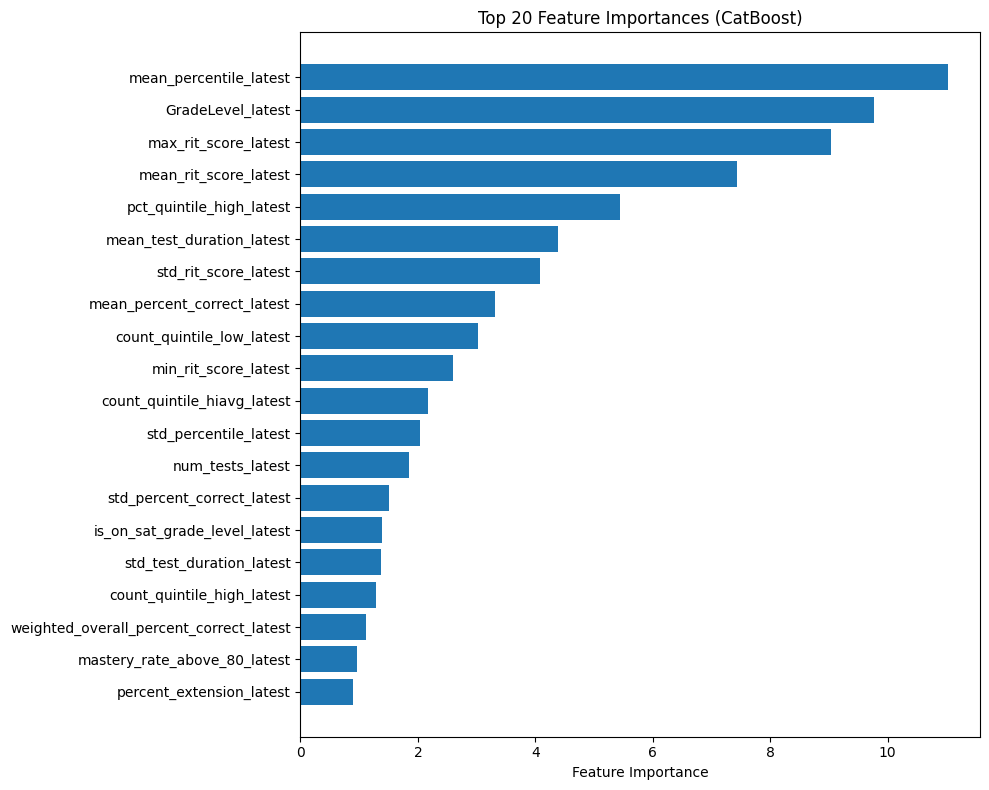

In [12]:
# Get feature importance (default is 'PredictionValuesChange')
feature_importance = best_model.get_feature_importance()

# Create a DataFrame for better visualization
feature_names = X.columns
importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features["importance"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (CatBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()